#  Customer Analysis

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [14]:
import time
from datetime import date

In [15]:
#import the model from sklearn
from sklearn import linear_model

#import evaluation metrics from sklearn
from sklearn.metrics import mean_squared_error, r2_score

#import TTsplit from sklearn
from sklearn.model_selection import train_test_split

In [16]:
data = pd.read_csv('marketing_customer_analysis.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'marketing_customer_analysis.csv'

## ## Customer Analysis - Round 2

In [ ]:
data.shape

**Standardize column names**

In [ ]:
data.rename(columns={'EmploymentStatus':'Employment Status'}, inplace=True)
data.rename(columns={'Unnamed:' ' 0':'unnamed:0'}, inplace=True)

columns = list(map(lambda x: x.strip('').lower().replace(' ','_'), data.columns))

#My first code with for loop
#columns=[]
#for i in range(len(data.columns)):
#    columns.append(data.columns[i].strip('').lower().replace(' ','_'))

#data.columns.lowercase()

data.columns = columns
#data.tail()

**get numerical data**

In [ ]:
data_numerical= data._get_numeric_data()
data_numerical.columns

**get categorical data**

In [ ]:
data_categorical = [column for column in data.columns if data[column].dtype=="O"]
data_categorical

**making data frame out of nulls and find proportions columns by columns**

In [ ]:
nullsdata = pd.DataFrame(round(data.isna().sum()/len(data),4)*100)
nullsdata = nullsdata.rename(columns={'index':'header',0:'proportion_of_nulls'})
#nullsdata

In [ ]:
data.isna().all(axis=1).value_counts() # no full Null row.

**deal with nulls, fill categorical data by 'Unknown', numerical data by its mean**

In [ ]:
data.drop(['vehicle_type'], axis = 1, inplace = True)  # There are a lot of null entries, so it makes sense just to remove it.

In [ ]:
data['state']=data['state'].fillna('Unknown')

In [ ]:
data['response']=data['response'].fillna('Unknown')

In [ ]:
data['vehicle_class']=data['vehicle_class'].fillna('Unknown')

In [ ]:
data['vehicle_size']=data['vehicle_size'].fillna('Unknown')

In [ ]:
#data[(data['data['number_of_open_complaints'].isna()].isna() & data['months_since_last_claim'].isna()) == True]
# number of open complaints and months since last claim rows are Null at the same time.

comp_mean = data['number_of_open_complaints'].mean()
data['number_of_open_complaints']=data['number_of_open_complaints'].fillna(comp_mean)

month_mean = data['months_since_last_claim'].mean()
data['months_since_last_claim']=data['months_since_last_claim'].fillna(month_mean)

#data.head()

**making effective_to_date as date time format**

In [ ]:
data['effective_to_date'] = pd.to_datetime(data['effective_to_date'],errors = 'coerce')

In [ ]:
data['month'] = pd.DatetimeIndex(data['effective_to_date']).month

In [ ]:
data['month'] = data['effective_to_date'].dt.strftime('%b')
#data.head()

In [ ]:
filtered = data.query("month == ['Jan', 'Feb', 'March']")

if filtered.shape == data.shape:  
    print('This data is just for the first quarter.')

In [ ]:
# if it is necessary we can find means of all categorical values.
#means =[]
#for i in data_numerical.columns:
#    means.append(data[i].mean()

#or by using map

means = list(map(lambda x: data[x].mean(), data_numerical.columns))
print(means)

## Customer Analysis - Round 3

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
data['response'].value_counts().plot(kind='bar',color='blue')

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x= 'sales_channel',hue='response',data=data)

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x="total_claim_amount", y="response", data=data)

In [ ]:
sns.displot(x='total_claim_amount', data= data, hue='response', kind='kde')

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x="income", y="response", data=data)

In [ ]:
sns.displot(x='income', data= data, hue='response', kind='kde')

In [ ]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=data, x="income", y="total_claim_amount",hue='response')

## Customer Analysis - Round 4

In [ ]:
data.info()

In [ ]:
numerical = data._get_numeric_data()
numerical


In [ ]:
data_categorical = [column for column in data.columns if data[column].dtype=="O"]

In [ ]:
for x in numerical.columns:
    sns.displot(data,x = x)


In [ ]:
numerical.hist(bins=30, figsize=(20, 50), layout=(9, 2));

Do the distributions for different numerical variables look like a normal distribution? 
Answer : No, they don't.

In [ ]:
corr_data = numerical
correlations_matrix = corr_data.corr()
correlations_matrix

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(correlations_matrix,annot= True)

## Customer Analysis + Prediction + Evaluation

- Aim is to predict the insurance claim amount.
Dealing with outliers. Normalization - ie use chosen scaler to transform selected columns into normal distribution as needed for linear regression model. Propose: MinMax scaler on 'effective_to_date' and standard scaler on numerical columns.

Encoding Categorical Data fields using OHE.

Bring categorical and numerical columns back together using pd.concat.

Define X and y, the y value you are seeking to predict is claim amount.

Splitting into train set and test dataset using random state, eg 80%:20% .

In [11]:
data['effective_to_date'] = data['effective_to_date'].apply(lambda x: x.toordinal())

NameError: name 'data' is not defined

### Dealing with outliers

In [ ]:
new_data = data.drop(['number_of_open_complaints','unnamed:0','months_since_policy_inception','number_of_policies','month','customer'],axis = 1) #independent variables /features
new_numerical = new_data._get_numeric_data()

for x in new_numerical.columns:
    q_1 = np.percentile(new_data[x],25)
    q_3 = np.percentile(new_data[x],75)
    iqr = q_3 - q_1
    
    lower_limit = q_1-(1.5)*iqr
    upper_limit = q_3+(1.5)*iqr
    number_of_lower_outliers = len(new_data[new_data[x]<lower_limit])
    number_of_upper_outliers = len(new_data[new_data[x]> upper_limit])
    print('The number of lower outliers of data[{}] is {}.'.format(x,number_of_lower_outliers))
    print('The number of upper outliers of data[{}] is {}.'.format(x,number_of_upper_outliers))
    new_data = new_data[(new_data[x] >= lower_limit) & (new_data[x]<= upper_limit)]
    print(new_data.shape)

In [ ]:
y = new_data['total_claim_amount']

In [ ]:
X = new_data.drop(['total_claim_amount'],axis = 1) #independent variables /features

In [ ]:
X_num = X.select_dtypes(include = np.number)  
X_num.head()
X_num.shape

In [ ]:
X.hist(bins=20,figsize=(15, 10), layout=(3, 2));

In [ ]:
X_cat = X.select_dtypes(include = np.object)
X_cat.head()

In [ ]:
from pandas.plotting import scatter_matrix
#plt.figure(figsize=(25,25))
scatter_matrix(X_num,alpha=0.2,figsize=(10,10),diagonal='kde');

### StandardScaler for Numerical Data

In [80]:
X_num = X_num.drop(['effective_to_date'],axis=1)
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(X_num)
X_standardised= transformer.transform(X_num)
X_num

(9283, 4)

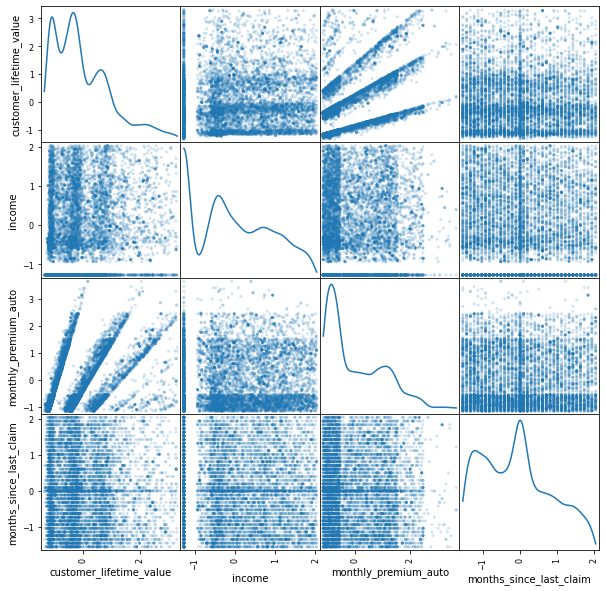

In [81]:
X_std=pd.DataFrame(X_standardised, columns= X_num.columns)
scatter_matrix(X_std,alpha=0.2,figsize=(10,10),diagonal='kde');
X_std.shape

### MinMaxScaler for 'effective_to_date'

In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X[['effective_to_date']])
date_minmax = scaler.transform(X[['effective_to_date']])

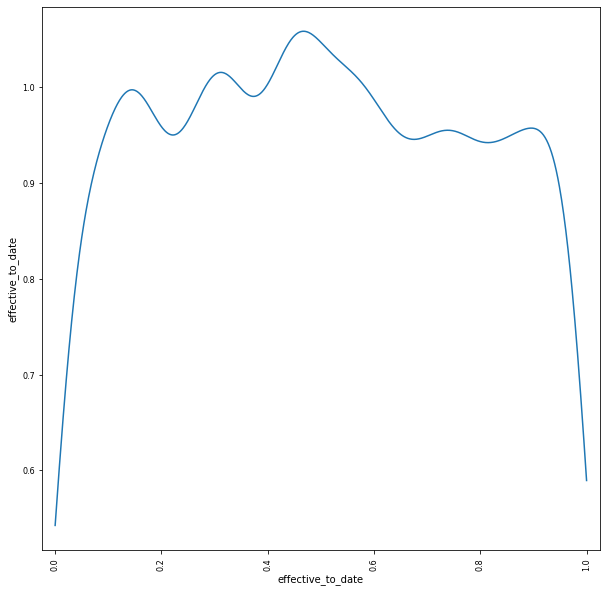

In [83]:
date_MinMax = pd.DataFrame(date_minmax, columns= ['effective_to_date'])
scatter_matrix(date_MinMax,alpha=0.2,figsize=(10,10),diagonal='kde');

### Encoding Categorical Data fields using OHE

In [84]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='error').fit(X_cat)
ohe = encoder.transform(X_cat).toarray()

In [85]:
ohedf = pd.DataFrame(ohe)
ohedf

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9278,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9279,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9280,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9281,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [100]:
newdata=pd.concat([ohedf,date_MinMax,X_std],axis=1)
newdata.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,effective_to_date,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.827586,-0.407054,0.315511,-1.143372,-0.827208
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.293103,-1.235429,-1.268956,-1.004858,-1.238455
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.689655,2.847365,-0.538595,0.657312,1.948710
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.275862,0.946191,-0.487923,1.442225,0.010613
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.758621,-0.427608,0.398645,-1.143372,-1.341267


### Train - Test Split

In [87]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(newdata,y, test_size=0.2, random_state=100)

In [88]:
X_train.shape

(7426, 64)

In [89]:
X_test.shape

(1857, 64)

### Model

In [92]:
from sklearn import linear_model 
from sklearn.metrics import r2_score, mean_squared_error 

In [93]:
lm=linear_model.LinearRegression()

In [94]:
#set up model and train it 
model=lm.fit(X_train,y_train)
#get the predictions on X test 
predictions=lm.predict(X_test)

In [95]:
#evaluate how good our predictions are 
r2_score(y_test,predictions)

# this is how much of the variation the model explains

0.7834276421368846

* The predicted total claim amount is 78% accurate with the test data.

In [97]:
mean_squared_error(y_test,predictions)


8621.604894980914

In [98]:
root_mean_squared = (mean_squared_error(y_test, predictions))**(1/2)
root_mean_squared

92.85259767492191

In [99]:
data.describe()

,unnamed:0,customer_lifetime_value,effective_to_date,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
count,10910.000000,10910.000000,10910.000000,10910.000000,10910.000000,10910.000000,10910.000000,10910.000000,10910.000000,10910.000000
mean,5454.500000,8018.241094,734166.951421,37536.284785,93.196059,15.149071,48.091934,0.384256,2.979193,434.888330
std,3149.590053,6885.081434,16.932418,30359.195670,34.442532,9.783520,27.940675,0.885589,2.399359,292.180556
min,0.000000,1898.007675,734138.000000,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,2727.250000,4014.453113,734153.000000,0.000000,68.000000,7.000000,24.000000,0.000000,1.000000,271.082527
50%,5454.500000,5771.147235,734167.000000,33813.500000,83.000000,15.000000,48.000000,0.000000,2.000000,382.564630
75%,8181.750000,8992.779137,734182.000000,62250.750000,109.000000,23.000000,71.000000,0.384256,4.000000,547.200000
max,10909.000000,83325.381190,734196.000000,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678
